# Classify Documents

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Set up Azure OpenAI

In [2]:
import os
import openai
from dotenv import load_dotenv

# Set up Azure OpenAI
load_dotenv()
openai.api_type = "azure"
openai.api_base = "https://tutorial-openai-01-2023.openai.azure.com/"
openai.api_version = "2022-12-01"
openai.api_key = os.getenv("OPENAI_API_KEY")

True

## Load Data

In [5]:
import pandas as pd

df_orig = pd.read_csv("../data/bbc-news-data-embedding.csv", delimiter='\t', index_col=False)

In [10]:
df = df_orig.copy()
df

,category,filename,title,content,embedding
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,"[-0.0012276918860152364, 0.00733763724565506, ..."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[0.0009311728645116091, 0.014099937863647938, ..."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,"[-0.010487922467291355, 0.009665092453360558, ..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"[0.0111119095236063, 0.004624682944267988, -0...."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[-0.0021637482568621635, 0.005410161800682545,..."
...,...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,"[0.007671569474041462, 0.00624304823577404, -0..."
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,"[0.0026338498573750257, 0.015989987179636955, ..."
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...,"[0.007126151118427515, 0.008495588786900043, -..."
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,"[0.002447678940370679, 0.006076449993997812, -..."


In [11]:
# drop rows with NaN
df.dropna(inplace=True)
len(df)

2217

## Deploy a model

In [8]:
# list models deployed with embeddings capability
deployment_id = None
result = openai.Deployment.list()

for deployment in result.data:
    if deployment["status"] != "succeeded":
        continue
    
    model = openai.Model.retrieve(deployment["model"])
    if model["capabilities"]["embeddings"] != True:
        continue
    
    deployment_id = deployment["id"]
    break

# if not model deployed, deploy one
if not deployment_id:
    print('No deployment with status: succeeded found.')
    model = "text-similarity-davinci-001"

    # Now let's create the deployment
    print(f'Creating a new deployment with model: {model}')
    result = openai.Deployment.create(model=model, scale_settings={"scale_type":"standard"})
    deployment_id = result["id"]
    print(f'Successfully created {model} with deployment_id {deployment_id}')
else:
    print(f'Found a succeeded deployment that supports embeddings with id: {deployment_id}.')

Found a succeeded deployment that supports embeddings with id: deployment-89153abdfa934e1580296dbee586239b.


## Classify documents with their embeddings
ref: https://github.com/openai/openai-cookbook/blob/main/examples/Classification_using_embeddings.ipynb

In [16]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# convert string to array
df["embedding"] = df['embedding'].apply(eval).apply(np.array)  

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2217 entries, 0 to 2223
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   2217 non-null   object
 1   filename   2217 non-null   object
 2   title      2217 non-null   object
 3   content    2217 non-null   object
 4   embedding  2217 non-null   object
dtypes: object(5)
memory usage: 103.9+ KB


In [33]:
X = df['embedding']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y) 

# reshape X into 2D array
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [39]:
from xgboost import XGBClassifier

# create model instance
xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=1, objective='multi:softprob')
# fit model
xgb.fit(X_train, y_train)

# predict
preds = xgb.predict(X_test)
probas = xgb.predict_proba(X_test)

# report
report = classification_report(y_test, preds)
print(report)

[15:51:21] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

               precision    recall  f1-score   support

     business       0.92      0.92      0.92       168
entertainment       0.94      0.93      0.93       127
     politics       0.90      0.90      0.90       137
        sport       0.98      0.98      0.98       168
         tech       0.92      0.93      0.93       132

     accuracy                           0.93       732
    macro avg       0.93      0.93      0.93       732
 weighted avg       0.93      0.93      0.93       732



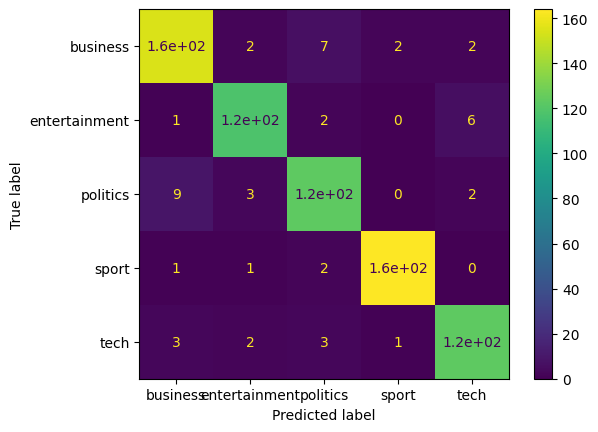

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_).plot()


In [41]:
# train random forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probas = rf.predict_proba(X_test)

rf_report = classification_report(y_test, rf_preds)
print(rf_report)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

               precision    recall  f1-score   support

     business       0.94      0.94      0.94       168
entertainment       0.95      0.94      0.94       127
     politics       0.94      0.93      0.94       137
        sport       0.99      1.00      0.99       168
         tech       0.95      0.95      0.95       132

     accuracy                           0.95       732
    macro avg       0.95      0.95      0.95       732
 weighted avg       0.95      0.95      0.95       732



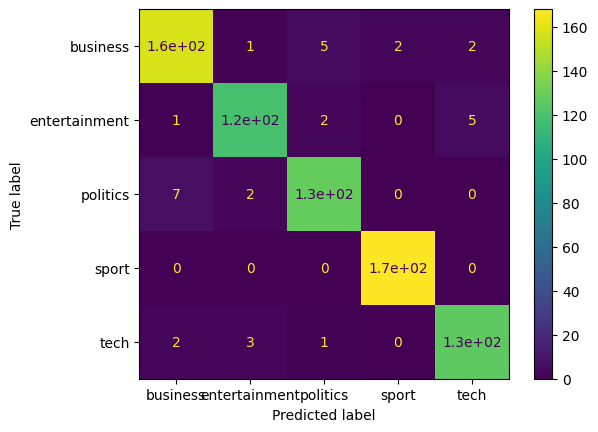

In [48]:
rf_cm = confusion_matrix(y_test, rf_preds)

rf_cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf.classes_).plot()

## Examples of correct classification

## Examples of incorrect classification